# Feature Extraction: MiniProject for Animal Census CPP

**About the Project:** Many species of animals are gong extinct due to poaching. Keeping a regular count of these animals would be helpful. For constant monitoring of these animals, camera traps are setup in forests that caputre pictures when it detects an animal passing by. The volume of data generated by these camera traps is huge and it is humanly not possible to go through all the images and identify individual animals.

The goal of this project is to come up with techniques to be able to uniquely identify individual members of the spotted deer species by obtaining some specific features. 

An important step in this task is to identify features in the image and use them to identify similar individuals. In the real world, data is rarely uniform and simple pixels will not be suitable for the task of object recognition. This has led to a large literature on *feature extraction* methods for image data which take into consideration the macroscopic details of the image rather than individual pixel data.

In this notebook, we will take a look at one such feature extraction technique, the **Histogram of Oriented Gradients (HOG)**, which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.

We begin with the standard imports:

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, color, feature, exposure
from skimage.feature import hog
from skimage.io import imread, imshow
%matplotlib inline

## HOG Features

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images.
HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

### TASK 1: Implementing the HOG Feature Extractor from skimage library

Check out the hog function in skimage.feature and create the HOG feature vector of the given image and visualise its HOG features and display the HOG vector.

(128, 64, 3)
The HOG features are: [0.         0.         0.         ... 0.34088067 0.04504277 0.03468313]
The number of features: 3780


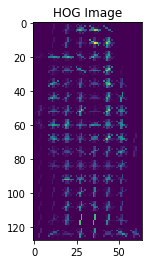

In [7]:
# Your code below
img=cv.imread('Test Image.png')
print(img.shape) # Image has correct dimensions

# Creating and displaying the HOG feature vector 
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
print("The HOG features are:", fd)
print("The number of features:", fd.shape[0])

# Visualizing the HOG features
plt.imshow(hog_image)
plt.title('HOG Image')
plt.show()
print(cv.cartToPolar())

Play around with the parameters of the function and try to understand what each parameter does.

### TASK 2: Implementing our own HOG feature Extractor

Using the same image as TASK 1, and following the steps mentioned above, we'll create our own algorithm using only numpy to find the HOG features. 

Go through this [link](https://www.learnopencv.com/histogram-of-oriented-gradients/) to get a better undestanding on the steps to extract HOG features

In [8]:
def compute_gradients(img):
    img=np.float32(img)/255.
    gx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=1)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=1)
    mag, angle = cv.cartToPolar(gx, gy, angleInDegrees=True)
    mag=np.absolute(mag)
    angle=np.absolute(angle)
    img_mag,img_mag_index=np.amax(mag,axis=2),np.argmax(mag,axis=2)
    img_dir=[]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_dir.append(angle[i,j,img_mag_index[i,j]])
    img_dir=np.array(img_dir)
    img_dir.shape=(img.shape[0],img.shape[1])
    return img_mag, img_dir
  # Function that computes the gradients/edges for each pixel along the x and y directions 
  # Checkout edge detecting algorithms like sobel in opencv
  # Find the magnitude and direction of these gradients obtained
  # Function should return two arrays having the same shape as the image, for the magnitude and direction

img_mag, img_dir = compute_gradients(img)

After obtaining the gradients, the next task is to define functions to generate histograms of each cell. 
Write your code for the following functions assuming you get only one cell as input instead of the entire image.

In [9]:
cell_size = 8  # to create the histogram
n_bins = 9 # number of bins
block_size = 16  # for block normalisation

In [10]:
# your code for your histogram creation using numpy assuming you get only one cell as input
def interval(theta,bins):
    d=180/bins
    a=0
    b=0
    for n in range(1,bins+1):
        thresh=(n-1)*d
        if theta>=thresh:
            a=n-1
    b=a+1
    return a,b

def histogram(mag_,angle_,bins):
    hist=[0,0,0,0,0,0,0,0,0]
    d=180./bins
    for i in range(mag_.shape[0]):
        for j in range(mag_.shape[1]):
            theta=angle_[i,j]
            a,b=interval(theta,bins)
            low,high=a*d,b*d
            magnitude=mag_[i,j]
            if b==bins:
                b=0
            hist[a]=hist[a]+(((high-theta)/(d))*(magnitude))
            hist[b]=hist[b]+(((theta-low)/(d))*(magnitude))
    return hist        

While writing your code above a few things should be kept in mind.
Try to break up the problem into smaller tasks and try to solve each of them one at a time.

After you obtain the histogram for one cell, loop through the image and create the histograms for each cell.

Make sure that the image dimensions are a multipe of the block size you've chosen. Otherwise resize your image appropriately.



In [15]:
# code to find histograms of all the cells in the image
def hog(mag_,angle_,cell,bins):
    hog=[]
    for i in range(0,mag_.shape[0],cell):
        for j in range(0,mag_.shape[1],cell):
            hog.append(histogram(mag_[i:i+cell,j:j+cell],angle_[i:i+cell,j:j+cell],bins))
    hog=np.array(hog)
    hog.shape=(np.int32(mag_.shape[0]/cell),np.int32(mag_.shape[1]/cell),bins)
    return hog        

hog = hog(img_mag, img_dir, cell_size, n_bins)

Now we have to normalize these histograms to make our code invariant to lighting variations.
Define a bock size and concatenate the feature vectors. Now normalize the concatenated vector.
Check out functions to normalize vectors in numpy.

In [17]:
# code to normalize the feature vector of one block
def normalize(block):
    norm=np.linalg.norm(block)
    norm_block=block/norm
    return norm_block

Now we loop over the HOG feature vectors obtained from each cell and normalize each block.
Concatenate these feature vectors to create the HOG feature representation for the image

In [20]:
# loop to normalize each block and concatenate the normalized vectors into a single feature vector
def block_normalize(hog,cell,block):
    r=np.int32(block/cell)
    norm_hog=[]
    for i in range(hog.shape[0]-r+1):
        for j in range(hog.shape[1]-r+1):
            vector=normalize(hog[i:i+r,j:j+r,:])
            norm_hog.append(vector)
    return norm_hog        

norm_hog = block_normalize(hog, cell_size, block_size)

c:\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Feel free to ask any doubts or questions on the group